In [4]:
import imp
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools

from lib.dense_layers import DenseLayer, EiDense, ColumnEiDense
from lib.base_rnn import RNNCell 
from lib.model import Model
from lib.dann_rnn import EiRNNCell
from lib.song_rnn import ColumnEiCell
from lib.update_policies import EiRNN_cSGD_UpdatePolicy, DalesANN_cSGD_UpdatePolicy, ColumnEiSGD_Clip, ColumnEiDenseSGD
from lib.init_policies import EiDenseWeightInit_WexMean, W_UniformInit, U_TorchInit, W_TorchInit, ColumnEiCell_W_InitPolicy, ColumnEi_FirstCell_U_InitPolicy, EiRNNCell_U_InitPolicy, EiRNNCell_W_InitPolicy

from lib import utils
from lib import rnn_basic_tasks
from lib.utils import acc_func
from config import PLAYGROUND_DIR
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

results_dir = PLAYGROUND_DIR/"seq_mnist_test"


In [20]:
sv_ratio = np.zeros((3,5))
for ind,n_hidden in enumerate([100, 300, 1000]):
    input_features = 28
    n_output_classes  = 10
    for seed in [0,1,2,3,4]:
        utils.set_seed_all(seed)
        cells = [ColumnEiCell(input_features, (n_hidden, 9),nonlinearity=F.relu, i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(dataset='MNIST'), h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=2.0), update_policy=ColumnEiSGD_Clip()),
                 ColumnEiDense(n_hidden, (n_output_classes, 9), nonlinearity=None, update_policy=ColumnEiDenseSGD())
                ]
        model = Model(cells)
        # print(model.state_dict()['module_dict.0.W_pos'])
        # print(model.state_dict()['module_dict.0.D_W'])
        rec_weights = model.state_dict()['module_dict.0.W_pos'] @ model.state_dict()['module_dict.0.D_W']
        _, song_sigma, _ = np.linalg.svd(rec_weights)
        print(np.sum(song_sigma>1.5)/np.sum(song_sigma<1.5), n_hidden)
        sv_ratio[ind, seed]=np.sum(song_sigma>1.5)/np.sum(song_sigma<1.5)
sv_ratio = sv_ratio.reshape(-1)

0.010101010101010102 100
0.010101010101010102 100
0.010101010101010102 100
0.010101010101010102 100
0.010101010101010102 100
0.0033444816053511705 300
0.0033444816053511705 300
0.0033444816053511705 300
0.0033444816053511705 300
0.0033444816053511705 300
0.001001001001001001 1000
0.001001001001001001 1000
0.001001001001001001 1000
0.001001001001001001 1000
0.001001001001001001 1000


In [21]:
seeds=5
dann_rnn = {k: np.zeros((seeds,1875)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
song_rnn = {k: np.zeros((seeds,1875)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
transparency = 0.2
song_acc_list = []

leg = ["n=100", "n=300", "n=1000"]
for ind, size in enumerate([100, 300, 1000]):
    for i in [0,1,2,3,4]:
        if size == 100: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 100)
        if size == 300: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 300)
        if size == 1000: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 1000)
        s = np.load(f'/network/projects/linclab_users/danns/playground/seq_mnist_test_song_shallow_NC/batch_size-32/seed-{i}/song_learning_curves_seed{i}_hidden{hidden}_lr{lr}_GC{GC}_rad{rad}.npz')
            
        song_rnn["train_err"][i, :] = s["train_err"]
        song_rnn["test_err"][i, :] = s["test_err"]
        song_rnn["train_loss"][i, :] = s["train_loss"]
        song_rnn["test_loss"][i, :] = s["test_loss"]
        song_rnn["update"][i, :] = s["update"]
        
        song_acc_list.append(s["test_err"][-1])

In [22]:
reg = linregress(sv_ratio, song_acc_list)
print(reg.pvalue)

2.896456658068777e-07


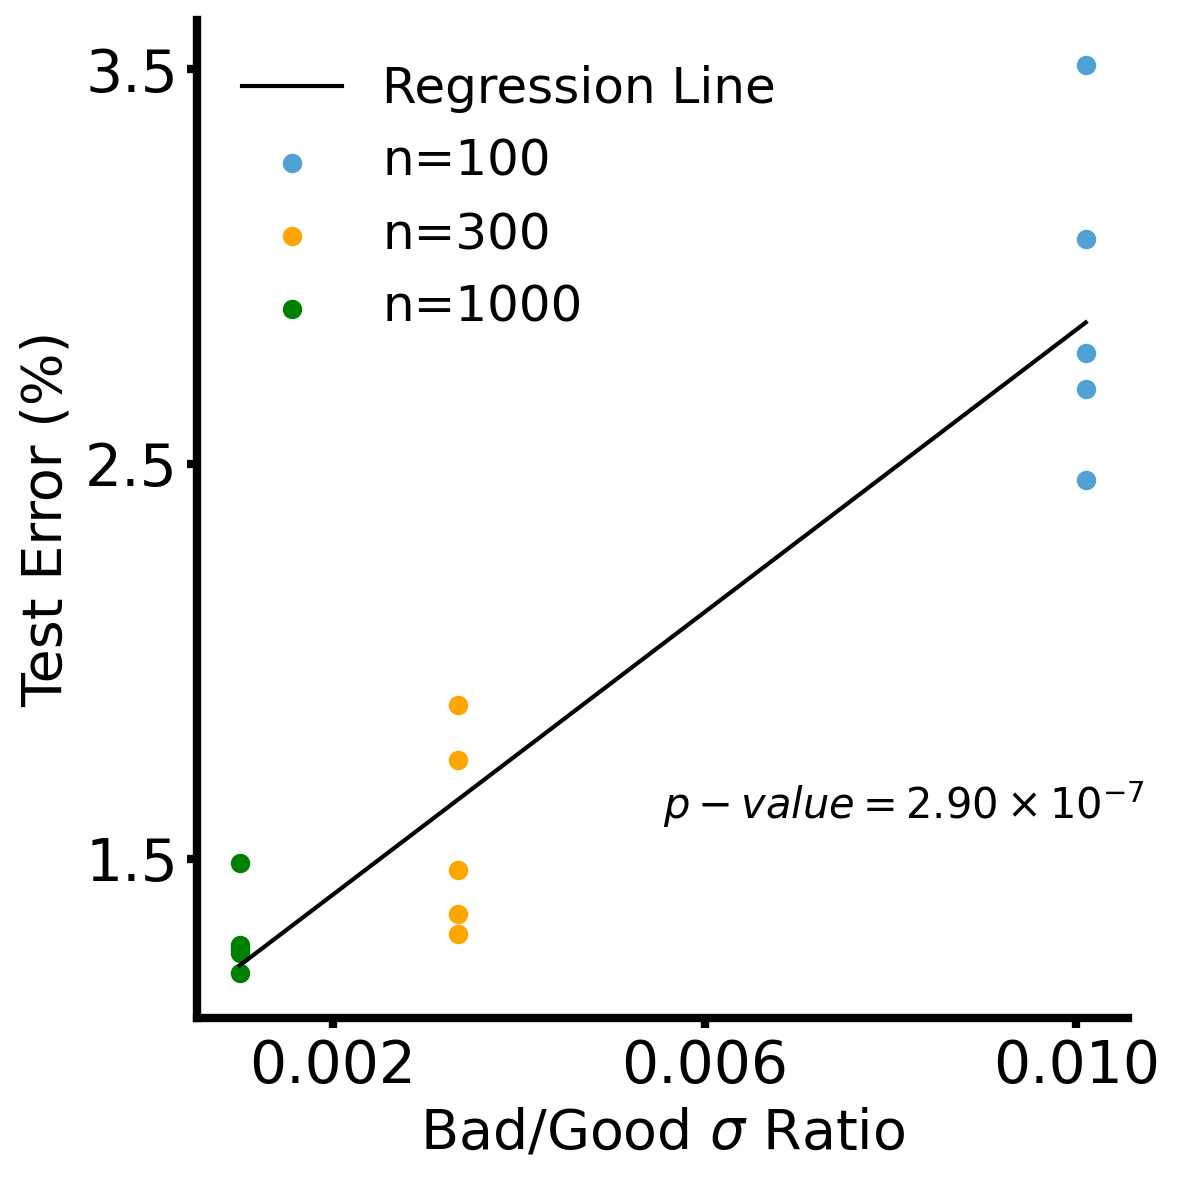

In [44]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (6,6)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
plt.plot(np.linspace(0.001,0.0101,num=10000),reg.slope*np.linspace(0.001,0.01,num=10000)+reg.intercept,c='k')
plt.scatter(sv_ratio[:5],song_acc_list[:5], color='#50a2d5')
plt.scatter(sv_ratio[5:10],song_acc_list[5:10], color='orange')
plt.scatter(sv_ratio[10:],song_acc_list[10:], color='green')
plt.legend(["Regression Line","n=100", "n=300","n=1000"], fontsize=18, frameon=False)
plt.annotate(r"$p-value=2.90 \times 10^{-7}$", fontsize=15,xy=(0.5, 0.2), xycoords='axes fraction')
plt.xlabel(r'Bad/Good $\sigma$ Ratio', fontsize=20)
plt.ylabel('Test Error (%)', fontsize=20)
plt.yticks(ticks=[1.5, 2.5, 3.5], size=21)
plt.xticks(ticks=[0.002, 0.006, 0.010], size=21)
plt.tight_layout()
# plt.savefig('exps/neural_comp/new_plots/SeqMNIST_Song_Test_Error_vs_SVratio.png', format='png', dpi=200)
# plt.savefig('exps/neural_comp/new_plots/SeqMNIST_Song_Test_Error_vs_SVratio.svg', format='svg', dpi=200)
plt.show()